# Neural Networks for Dynamical Systems

In [11]:
import numpy as np
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt

## Example 1. Simple Dynamical System:

In [350]:
def dx(x, *params):
    dx = np.array([
        1*(x[1] - x[2]) - 3*x[0],
        1*x[0]  - 2*x[1],
        1*x[1] - 1*x[2]- 3*x[2]
            ]) * dt
    return dx

In [116]:
def x_update(x):
    x_update = x.reshape(-1,3)[-1] + dx(x.reshape(-1,3)[-1])
    return x_update

In [117]:
def initialize(x):    
    
    input_ = np.array([x])
    output_ = np.array([])
    time_ = np.array([])
    
    return input_, output_, time_

In [118]:
def ode_solve(T, dt, cache):
    
    input_ = cache[0]
    output_ = cache[1]
    time_ = cache[2]

    for i, t in enumerate(np.arange(0, T, dt)):
        y = x_update(input_)
        input_ = np.append(input_.reshape(-1,3), y)
        output_ = np.append(output_.reshape(-1,3), y)
        time_ = np.append(time_.reshape(-1,1), t)
    
    y = input_.reshape(-1,3)[-1] + dx(input_.reshape(-1,3)[-1])
    output_ = np.append(output_.reshape(-1,3), y)
    input_ = input_.reshape(-1,3)
    output_ = output_.reshape(-1,3)
    time_ = np.append(time_.reshape(-1,1), t+dt)
    
    return input_, output_, time_

## Using Neural Network to approximate the Dynamical System

#### We consider `n` steps as one single data point

We consider `n` (instead of 1) steps as a single data point, mainly to account for the history of the signal.

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

In [367]:
T = 8
dt = 0.01

x = np.array([-3,-0.3, 10])

cache = initialize(x)
cache = ode_solve(T, dt, cache)
input_, output_, time_ = cache

n = 9;
layers = [32, 32, 32]

model = Sequential([
    Dense(units=layers[0], input_shape=(3*n,), kernel_initializer='normal', activation='sigmoid'),
    Dense(units=layers[1], kernel_initializer='normal', activation='linear'),
    Dense(units=layers[2], kernel_initializer='normal', activation='relu'),
    Dense(units=3*n, kernel_initializer='normal'),
])

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x=input_.reshape(-1,3*n), y=output_.reshape(-1,3*n), batch_size=10, epochs=1000, verbose=0)
prediction = model.predict(input_.reshape(-1,3*n))

In [368]:
def fcn_2Dplot(x, y, t):
    
    fig, ax = plt.subplots(3)
    min_len = min(x.reshape(-1,3).shape[0], y.reshape(-1,3).shape[0]) # when x, y has different length
    for i in range(3):
        ax[i].plot(t[:min_len], x.reshape(-1,3)[:min_len,i], 'r')
        ax[i].plot(t[:min_len], y.reshape(-1,3)[:min_len,i], 'b')       

In [369]:
def fcn_3Dplot(x, color):
    
    ax = plt.axes(projection='3d')
    xdata = x.reshape(-1,3)[:,0]
    ydata = x.reshape(-1,3)[:,1]
    zdata = x.reshape(-1,3)[:,2]
    ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap=color);

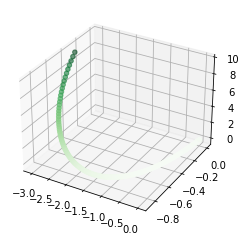

In [370]:
fcn_3Dplot(output_, color='Greens')

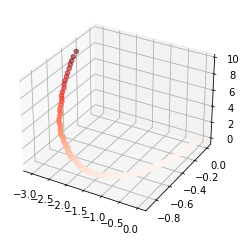

In [371]:
fcn_3Dplot(prediction, color='Reds')

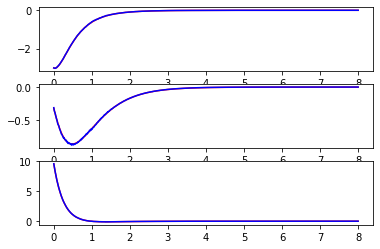

In [372]:
fcn_2Dplot(output_, prediction, time_)

### Evaluate the Model

In [1403]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [1404]:
def fn_model():
    # create model
    model = Sequential()
    model.add(Dense(units=10, input_shape=(3,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=3, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
estimator = KerasRegressor(build_fn=fn_model, epochs=50, batch_size=5, verbose=0)
kfold = KFold(n_splits=5)
results = cross_val_score(estimator, input_, output_, cv=kfold, error_score="raise")
print("Results:", results)
print("Results mean: %.2f (Resutls std: %.2f) MSE" % (results.mean(), results.std()))

### Validation on interval `[6.66, 8]`

In [364]:
def fcn_pred(cache, t1, t2):
    
    input_ = cache[0]
    output_ = cache[1]
    time_ = cache[2]
    
    prediction = input_[:int(t1/dt),:]
    
    for i, t in enumerate(np.arange(t1, t2, n*dt)):
        prediction = prediction.reshape(-1,3)
        prediction = np.append(prediction, model.predict(prediction.reshape(-1,3*n)[-1,:].reshape(-1,3*n)).reshape(-1,3))
        
    prediction = prediction.reshape(-1,3)
    prediction = np.append(prediction, model.predict(prediction.reshape(-1,3*n)[-1,:].reshape(-1,3*n)).reshape(-1,3))
    prediction = prediction.reshape(-1,3)
    
    input_ = input_[:int(t1/dt),:]
    output_ = output_[:int(t1/dt),:]
    time_ = time_[:int(t1/dt)]
    for i, t in enumerate(np.arange(t1, t2, dt)):
        y = x_update(input_)
        input_ = np.append(input_.reshape(-1,3), y)
        output_ = np.append(output_.reshape(-1,3), y)
        time_ = np.append(time_.reshape(-1,1), t)

    y = x_update(input_)
    output_ = np.append(output_.reshape(-1,3), y)
    input_ = input_.reshape(-1,3)
    output_ = output_.reshape(-1,3)
    time_ = np.append(time_.reshape(-1,1), t+dt)
    
    return input_, output_, prediction, time_

In [373]:
cache = initialize(x)
cache = ode_solve(T, dt, cache)
input_, output_, time_ = cache

input_, output_, prediction, time_ = fcn_pred(cache, 6.66, 8)

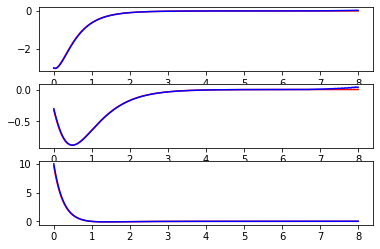

In [374]:
fcn_2Dplot(output_, prediction, time_)

### Predict on interval `[8, 15]`

In [375]:
cache = initialize(x)
cache = ode_solve(T, dt, cache)
input_, output_, time_ = cache

input_, output_, prediction, time_ = fcn_pred(cache, 8.01, 15)

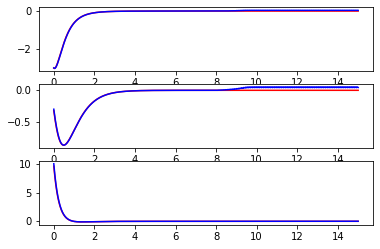

In [376]:
fcn_2Dplot(output_, prediction, time_)

## Example 2. Chaotic Dynamical System

Lorenz system parameters:

In [333]:
def dx(x): 
    b = 8/3
    sig = 10
    r = 28
    dx = np.array([
        sig * (x[1] - x[0]),
        r * x[0]  - x[0] * x[2] - x[1],
        x[0] * x[1] - b * x[2]
    ]) * dt
    return dx

In [339]:
T = 8
dt = 0.01

x = np.array([-3,-0.3, 10])

cache = initialize(x)
cache = ode_solve(T, dt, cache)
input_, output_, time_ = cache

n = 1;
layers = [10, 10, 10]

model = Sequential([
    Dense(units=layers[0], input_shape=(3*n,), kernel_initializer='normal', activation='sigmoid'),
    Dense(units=layers[1], kernel_initializer='normal', activation='linear'),
    Dense(units=layers[2], kernel_initializer='normal', activation='relu'),
    Dense(units=3*n, kernel_initializer='normal'),
])

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x=input_.reshape(-1,3*n), y=output_.reshape(-1,3*n), batch_size=10, epochs=1000, verbose=0)
prediction = model.predict(input_.reshape(-1,3*n))

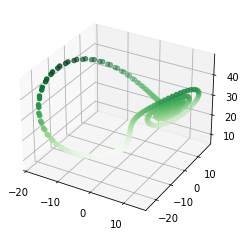

In [340]:
fcn_3Dplot(output_, color='Greens')

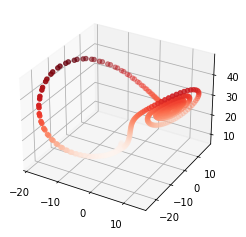

In [341]:
fcn_3Dplot(prediction, color='Reds')

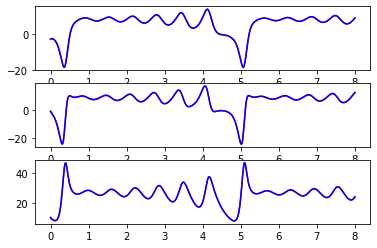

In [342]:
fcn_2Dplot(output_, prediction, time_)

### Validation on interval `[6.66, 8]`

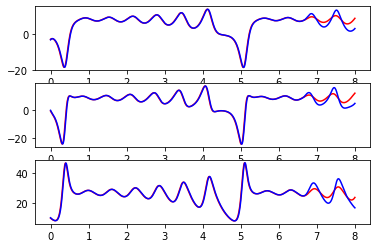

In [346]:
cache = initialize(x)
cache = ode_solve(T, dt, cache)
input_, output_, time_ = cache

input_, output_, prediction, time_ = fcn_pred(cache, 6.66, 8)
fcn_2Dplot(output_, prediction, time_)

### Predict on interval `[8, 15]`

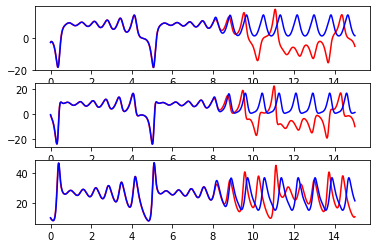

In [347]:
cache = initialize(x)
cache = ode_solve(T, dt, cache)
input_, output_, time_ = cache

input_, output_, prediction, time_ = fcn_pred(cache, 8.01, 15)
fcn_2Dplot(output_, prediction, time_)